In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Load the data
def load_data(file_path):
    """Load CSV file and return DataFrame"""
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
        return df
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None

# Initial data exploration
def explore_data(df):
    """Perform initial data exploration"""
    print("\n=== DATA EXPLORATION ===")
    print("\nFirst 5 rows:")
    print(df.head())
    
    print("\nDataset Info:")
    print(df.info())
    
    print("\nBasic Statistics:")
    print(df.describe())
    
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    print("\nDuplicate Rows:")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    
    if 'label' in df.columns or 'crop' in df.columns:
        target_col = 'label' if 'label' in df.columns else 'crop'
        print(f"\nTarget Variable Distribution ({target_col}):")
        print(df[target_col].value_counts())

# Load your data
df = load_data('crop_recommendation.csv')  # Replace with your file path
if df is not None:
    explore_data(df)

Data loaded successfully: 2200 rows, 8 columns

=== DATA EXPLORATION ===

First 5 rows:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label       

In [6]:
# Data cleaning pipeline
def clean_data(df):
    """Comprehensive data cleaning pipeline"""
    df_clean = df.copy()
    
    print("\n=== DATA CLEANING ===")
    
    # 1. Handle missing values
    missing_before = df_clean.isnull().sum().sum()
    print(f"Missing values before cleaning: {missing_before}")
    
    # For numerical columns, fill with median
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # For categorical columns, fill with mode
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")
    
    # 2. Remove duplicates
    duplicates_before = df_clean.duplicated().sum()
    df_clean = df_clean.drop_duplicates()
    print(f"Duplicates removed: {duplicates_before}")
    
    # 3. Handle outliers using IQR method
    print("\nOutlier handling:")
    for col in numerical_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
        if outliers > 0:
            print(f"  {col}: {outliers} outliers detected")
            # Cap outliers instead of removing
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
    
    # 4. Data type validation
    print("\nData types:")
    print(df_clean.dtypes)
    
    return df_clean

# Apply cleaning
df_clean = clean_data(df)


=== DATA CLEANING ===
Missing values before cleaning: 0
Missing values after cleaning: 0
Duplicates removed: 0

Outlier handling:
  P: 138 outliers detected
  K: 200 outliers detected
  temperature: 86 outliers detected
  humidity: 30 outliers detected
  ph: 57 outliers detected
  rainfall: 100 outliers detected

Data types:
N                int64
P              float64
K              float64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object



=== DATA ANALYSIS ===


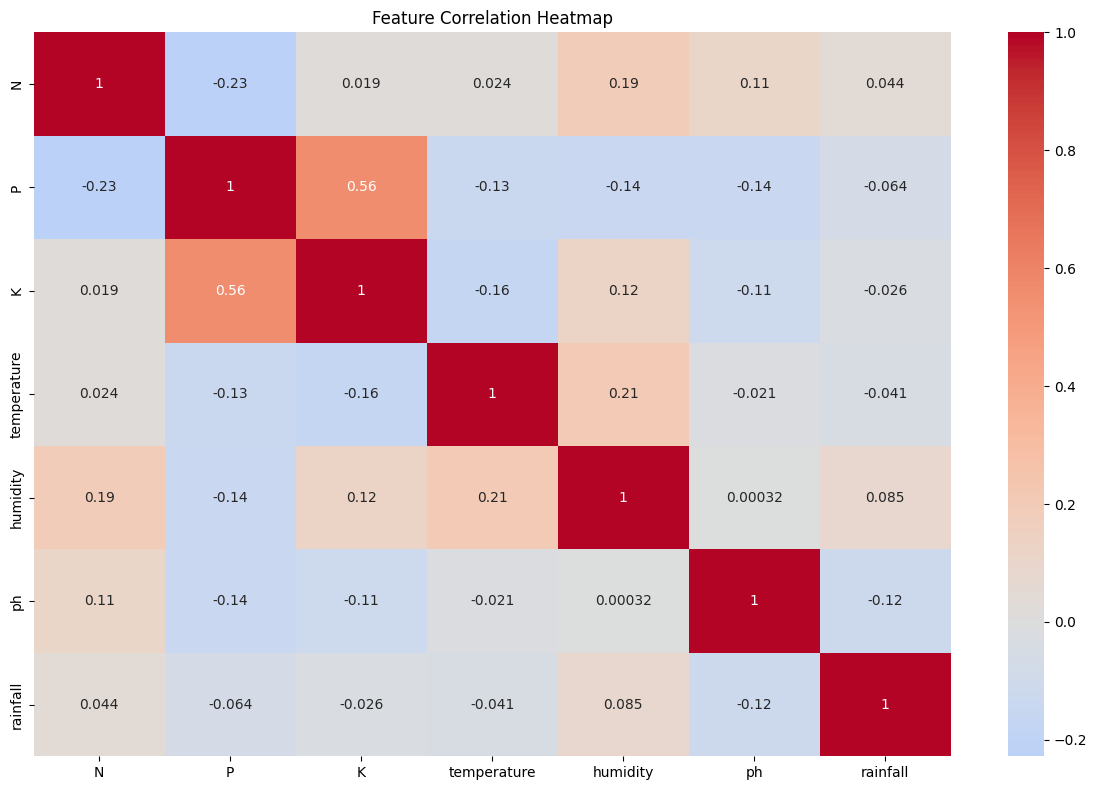

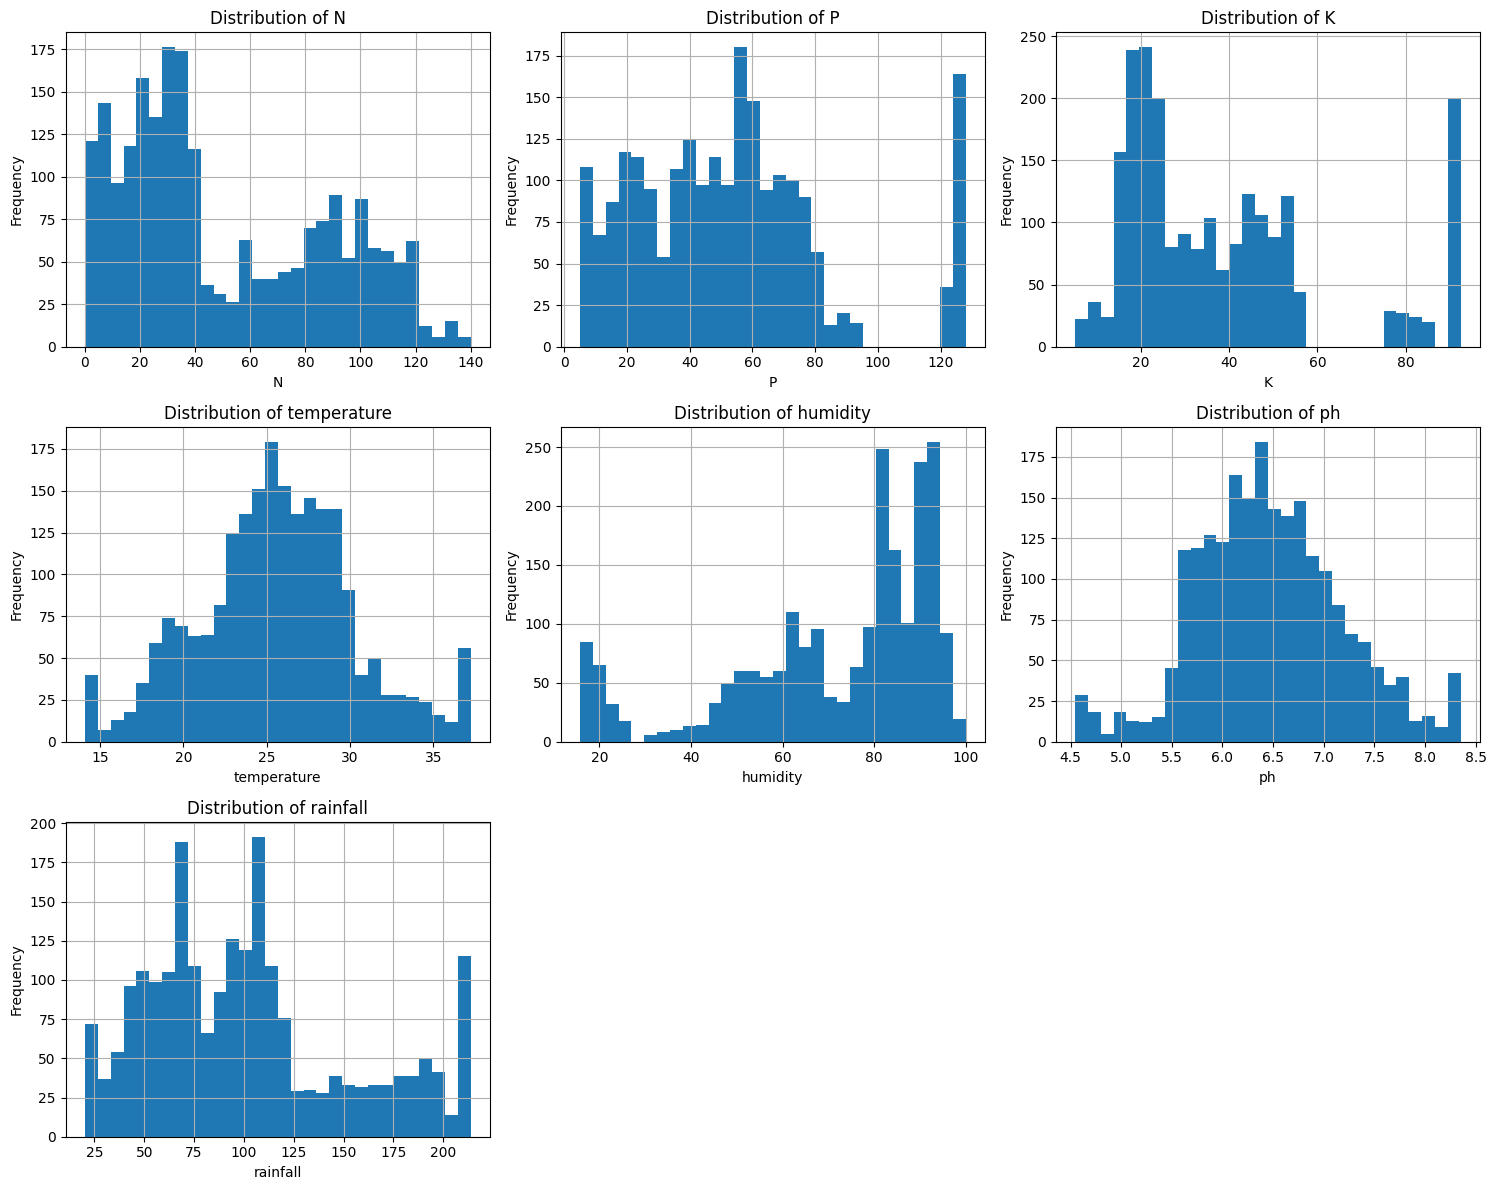

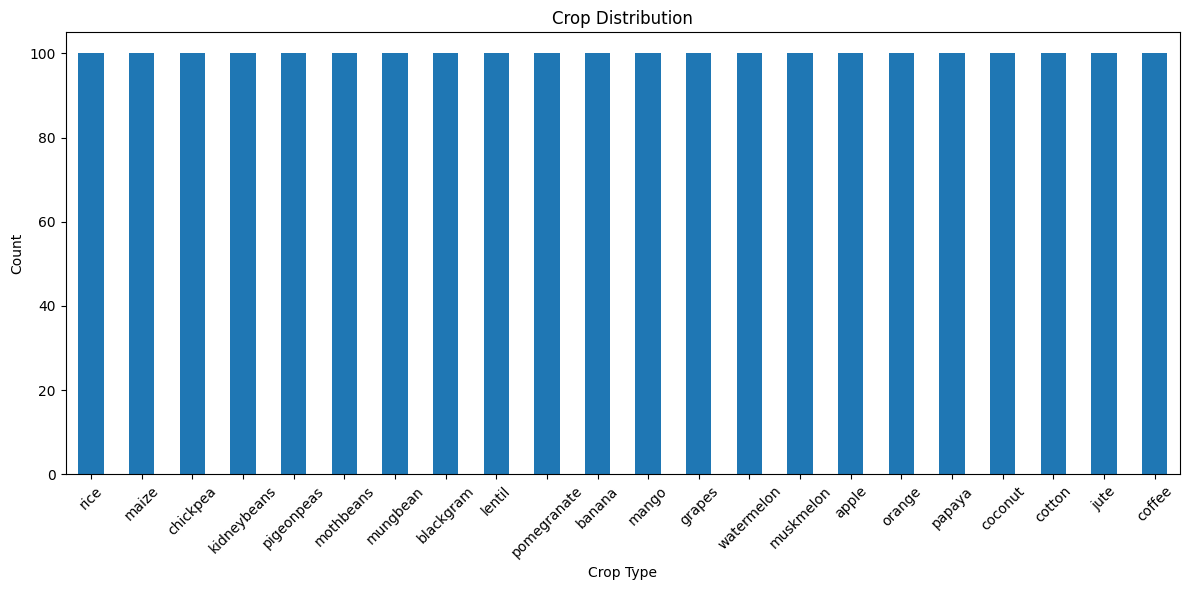

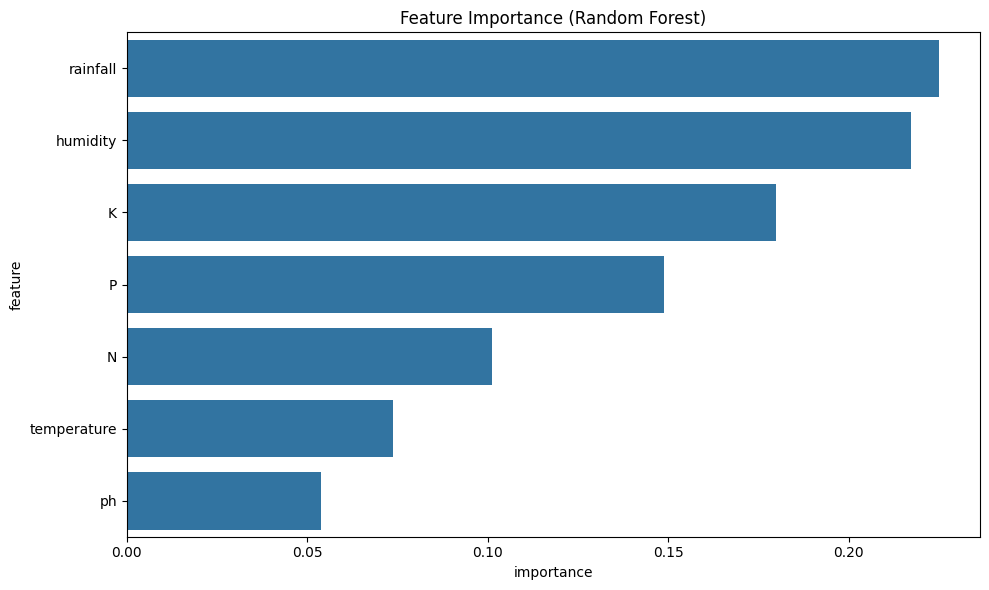

In [7]:
# Data Analysis and visualization
def analyze_data(df):
    """Perform data analysis and visualization"""
    print("\n=== DATA ANALYSIS ===")
    
    # Identify feature columns and target column
    if 'label' in df.columns:
        target_col = 'label'
    elif 'crop' in df.columns:
        target_col = 'crop'
    else:
        # Assume last column is target
        target_col = df.columns[-1]
    
    feature_cols = [col for col in df.columns if col != target_col]
    numerical_features = df[feature_cols].select_dtypes(include=[np.number]).columns
    
    # 1. Correlation heatmap
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[numerical_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # 2. Distribution of numerical features
    n_features = len(numerical_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_features):
        df[col].hist(bins=30, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Target distribution
    plt.figure(figsize=(12, 6))
    df[target_col].value_counts().plot(kind='bar')
    plt.title('Crop Distribution')
    plt.xlabel('Crop Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Feature importance (using random forest)
    if len(numerical_features) > 0:
        X = df[numerical_features]
        y = df[target_col]
        
        # Encode target if categorical
        if y.dtype == 'object':
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
        else:
            y_encoded = y
        
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y_encoded)
        
        feature_importance = pd.DataFrame({
            'feature': numerical_features,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature')
        plt.title('Feature Importance (Random Forest)')
        plt.tight_layout()
        plt.show()
        
        return feature_importance

feature_importance = analyze_data(df_clean)

In [8]:
# Model Training and Evaluation
def prepare_data(df):
    """Prepare data for machine learning"""
    # Identify target column
    if 'label' in df.columns:
        target_col = 'label'
    elif 'crop' in df.columns:
        target_col = 'crop'
    else:
        target_col = df.columns[-1]
    
    # Feature columns (all except target)
    feature_cols = [col for col in df.columns if col != target_col]
    
    X = df[feature_cols]
    y = df[target_col]
    
    # Encode target variable if categorical
    le = None
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    return X, y, le, feature_cols

def evaluate_models(X, y):
    """Evaluate multiple ML models"""
    print("\n=== MODEL EVALUATION ===")
    
    # Define models to test
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(random_state=42)
    }
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- {name} ---")
        
        # Create pipeline with scaling
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        # Cross-validation
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
        print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train and test
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.4f}")
        
        results[name] = {
            'model': pipeline,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_accuracy': accuracy,
            'predictions': y_pred,
            'true_labels': y_test
        }
    
    return results, X_test, y_test

# Prepare data and evaluate models
X, y, label_encoder, feature_cols = prepare_data(df_clean)
results, X_test, y_test = evaluate_models(X, y)


=== MODEL EVALUATION ===

--- Random Forest ---
Cross-validation Accuracy: 0.9945 (+/- 0.0068)
Test Accuracy: 0.9955

--- Logistic Regression ---
Cross-validation Accuracy: 0.9741 (+/- 0.0172)
Test Accuracy: 0.9795

--- SVM ---
Cross-validation Accuracy: 0.9855 (+/- 0.0074)
Test Accuracy: 0.9909



=== RESULTS ANALYSIS ===

Model Comparison:
                 Model  CV Mean Accuracy    CV Std  Test Accuracy
0        Random Forest          0.994545  0.003402       0.995455
2                  SVM          0.985455  0.003693       0.990909
1  Logistic Regression          0.974091  0.008576       0.979545


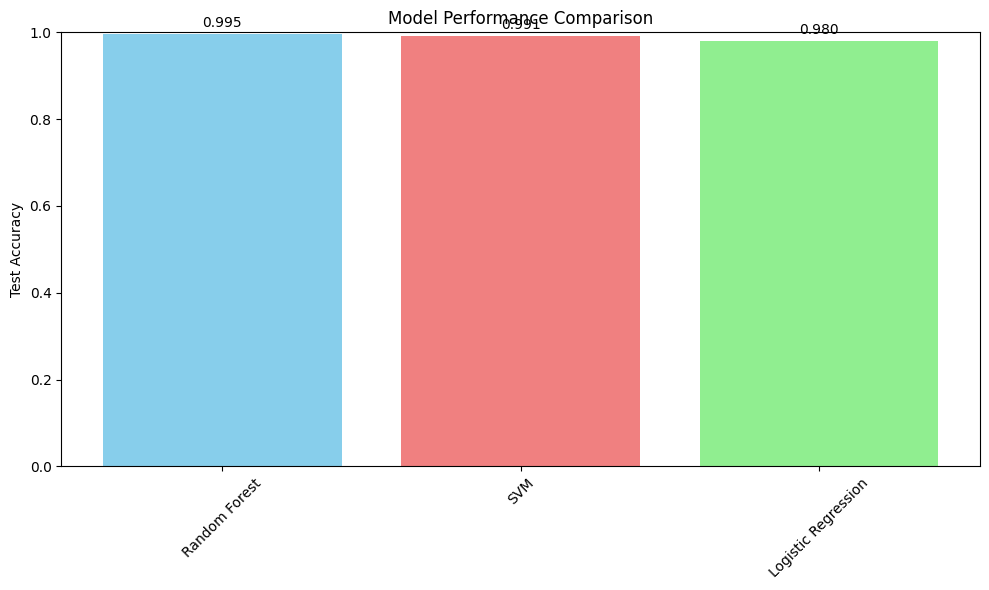


Best Model: Random Forest
Best Test Accuracy: 0.9955

Classification Report for Random Forest:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      

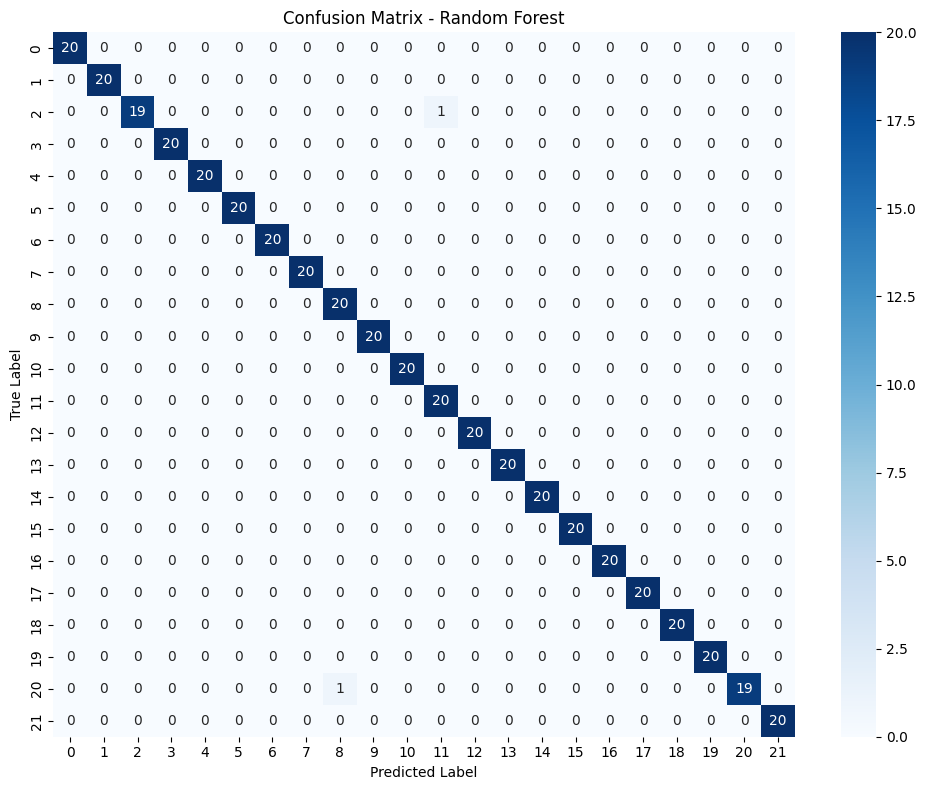

In [9]:
# Results analysis and model interpretation
def analyze_results(results, X_test, y_test, label_encoder=None):
    """Analyze and compare model results"""
    print("\n=== RESULTS ANALYSIS ===")
    
    # Compare model performance
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'CV Mean Accuracy': [results[model]['cv_mean'] for model in results],
        'CV Std': [results[model]['cv_std'] for model in results],
        'Test Accuracy': [results[model]['test_accuracy'] for model in results]
    }).sort_values('Test Accuracy', ascending=False)
    
    print("\nModel Comparison:")
    print(comparison_df)
    
    # Plot performance comparison
    plt.figure(figsize=(10, 6))
    models = comparison_df['Model']
    test_acc = comparison_df['Test Accuracy']
    
    plt.bar(models, test_acc, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Model Performance Comparison')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for i, v in enumerate(test_acc):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed analysis of best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    y_pred = results[best_model_name]['predictions']
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Best Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")
    
    # Classification report
    print(f"\nClassification Report for {best_model_name}:")
    if label_encoder:
        target_names = label_encoder.classes_
        print(classification_report(y_test, y_pred, target_names=target_names))
    else:
        print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    
    if label_encoder and len(label_encoder.classes_) <= 20:  # Only plot if not too many classes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return best_model_name, best_model

best_model_name, best_model = analyze_results(results, X_test, y_test, label_encoder)

In [10]:
# data quality assement
def assess_data_quality(df, results):
    """Assess if the data is fit for machine learning"""
    print("\n=== DATA QUALITY ASSESSMENT ===")
    
    # Identify target column
    if 'label' in df.columns:
        target_col = 'label'
    elif 'crop' in df.columns:
        target_col = 'crop'
    else:
        target_col = df.columns[-1]
    
    quality_metrics = {}
    
    # 1. Dataset size assessment
    n_samples, n_features = df.shape
    quality_metrics['Sample Size'] = n_samples
    quality_metrics['Number of Features'] = n_features
    
    print(f"Dataset Size: {n_samples} samples, {n_features} features")
    
    # 2. Class distribution assessment
    class_distribution = df[target_col].value_counts()
    min_class_size = class_distribution.min()
    max_class_size = class_distribution.max()
    imbalance_ratio = max_class_size / min_class_size if min_class_size > 0 else float('inf')
    
    quality_metrics['Number of Classes'] = len(class_distribution)
    quality_metrics['Imbalance Ratio'] = imbalance_ratio
    quality_metrics['Min Class Size'] = min_class_size
    
    print(f"Number of classes: {len(class_distribution)}")
    print(f"Class imbalance ratio: {imbalance_ratio:.2f}")
    
    # 3. Missing data assessment
    missing_total = df.isnull().sum().sum()
    missing_percentage = (missing_total / (n_samples * n_features)) * 100
    quality_metrics['Missing Data Percentage'] = missing_percentage
    
    print(f"Missing data: {missing_percentage:.2f}%")
    
    # 4. Model performance assessment
    best_accuracy = max([results[model]['test_accuracy'] for model in results])
    quality_metrics['Best Model Accuracy'] = best_accuracy
    
    print(f"Best model accuracy: {best_accuracy:.4f}")
    
    # 5. Overall assessment
    print("\n--- DATA QUALITY VERDICT ---")
    
    issues = []
    
    if n_samples < 100:
        issues.append("Small dataset size")
    elif n_samples < 500:
        issues.append("Moderate dataset size")
    
    if imbalance_ratio > 10:
        issues.append("High class imbalance")
    elif imbalance_ratio > 5:
        issues.append("Moderate class imbalance")
    
    if missing_percentage > 5:
        issues.append("Significant missing data")
    
    if best_accuracy < 0.7:
        issues.append("Poor model performance")
    elif best_accuracy < 0.85:
        issues.append("Moderate model performance")
    
    if not issues:
        print("✅ EXCELLENT: Data appears to be well-suited for machine learning")
        print("   - Good dataset size")
        print("   - Balanced classes")
        print("   - Minimal missing data")
        print("   - High model performance")
    else:
        print("⚠️  DATA QUALITY ISSUES DETECTED:")
        for issue in issues:
            print(f"   - {issue}")
        
        print("\nRecommendations:")
        if "Small dataset size" in issues:
            print("   - Collect more data")
        if "class imbalance" in issues:
            print("   - Use techniques like SMOTE or class weights")
        if "missing data" in issues:
            print("   - Improve data collection process")
        if "Poor model performance" in issues:
            print("   - Feature engineering needed")
            print("   - Consider different algorithms")
            print("   - Check for data quality issues")
    
    return quality_metrics

quality_metrics = assess_data_quality(df_clean, results)


=== DATA QUALITY ASSESSMENT ===
Dataset Size: 2200 samples, 8 features
Number of classes: 22
Class imbalance ratio: 1.00
Missing data: 0.00%
Best model accuracy: 0.9955

--- DATA QUALITY VERDICT ---
✅ EXCELLENT: Data appears to be well-suited for machine learning
   - Good dataset size
   - Balanced classes
   - Minimal missing data
   - High model performance


🚀 STARTING CROP RECOMMENDATION PIPELINE
Data loaded successfully: 2200 rows, 8 columns

=== DATA CLEANING ===
Missing values before cleaning: 0
Missing values after cleaning: 0
Duplicates removed: 0

Outlier handling:
  P: 138 outliers detected
  K: 200 outliers detected
  temperature: 86 outliers detected
  humidity: 30 outliers detected
  ph: 57 outliers detected
  rainfall: 100 outliers detected

Data types:
N                int64
P              float64
K              float64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

=== DATA ANALYSIS ===


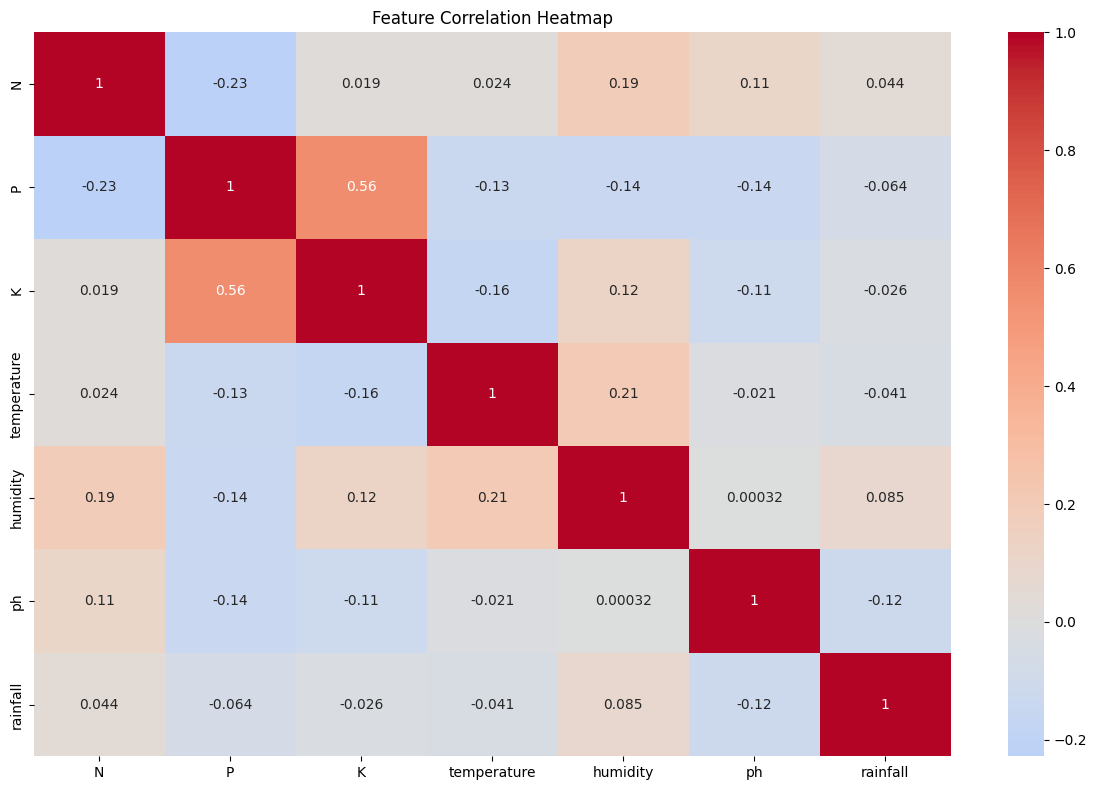

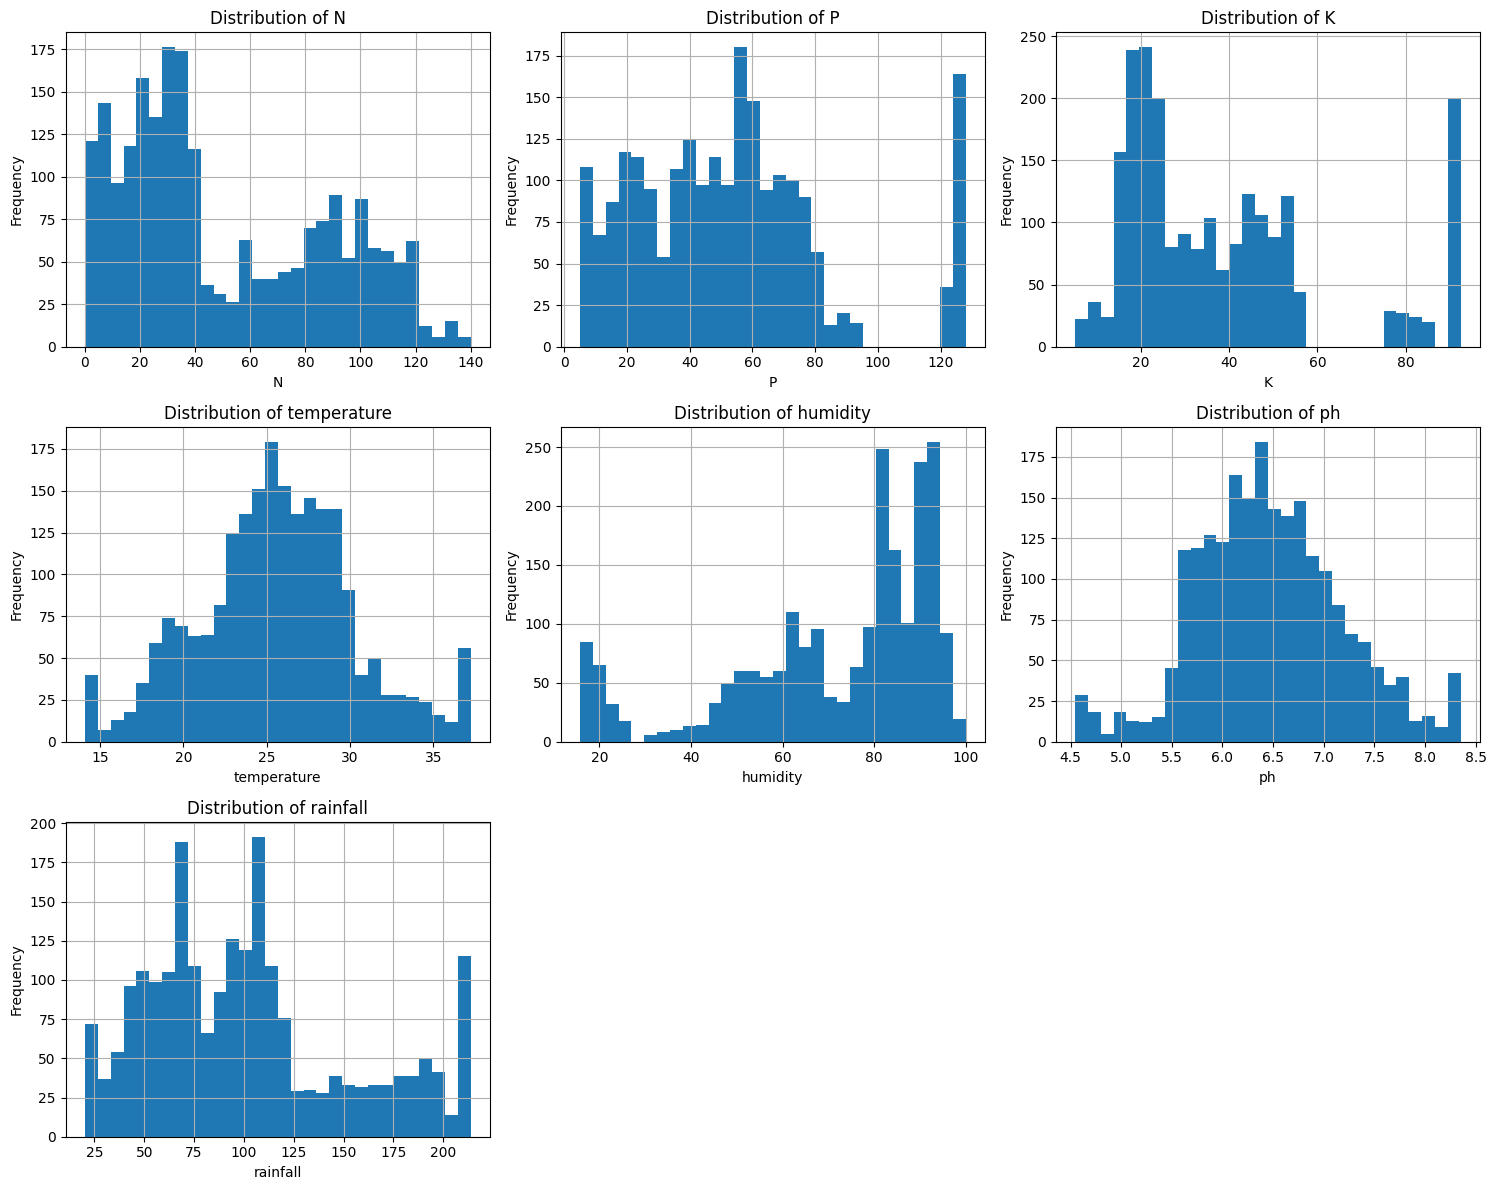

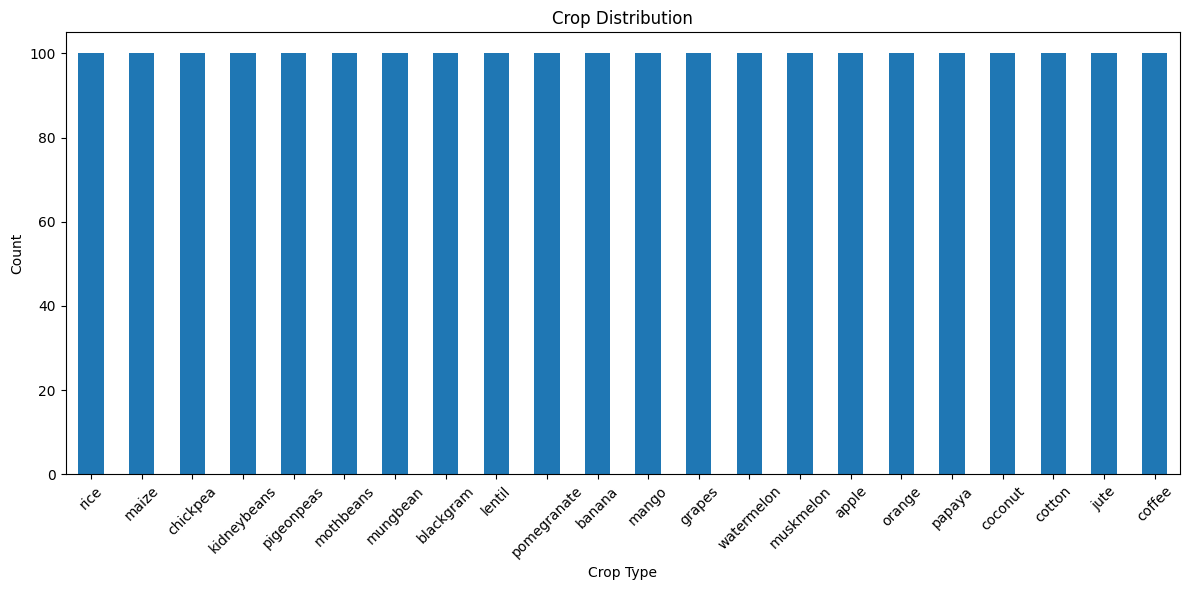

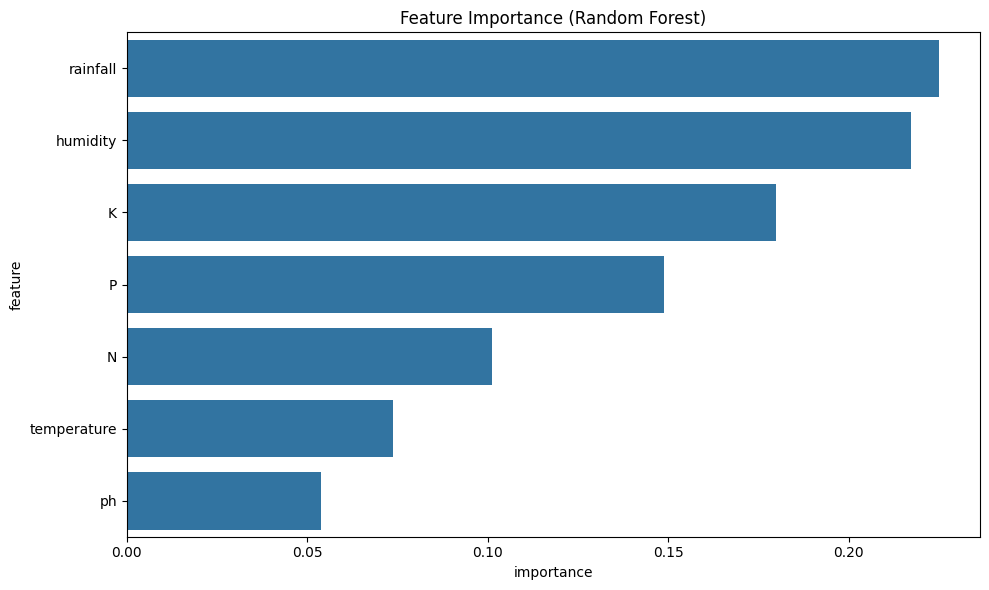


=== MODEL EVALUATION ===

--- Random Forest ---
Cross-validation Accuracy: 0.9945 (+/- 0.0068)
Test Accuracy: 0.9955

--- Logistic Regression ---
Cross-validation Accuracy: 0.9741 (+/- 0.0172)
Test Accuracy: 0.9795

--- SVM ---
Cross-validation Accuracy: 0.9855 (+/- 0.0074)
Test Accuracy: 0.9909

=== RESULTS ANALYSIS ===

Model Comparison:
                 Model  CV Mean Accuracy    CV Std  Test Accuracy
0        Random Forest          0.994545  0.003402       0.995455
2                  SVM          0.985455  0.003693       0.990909
1  Logistic Regression          0.974091  0.008576       0.979545


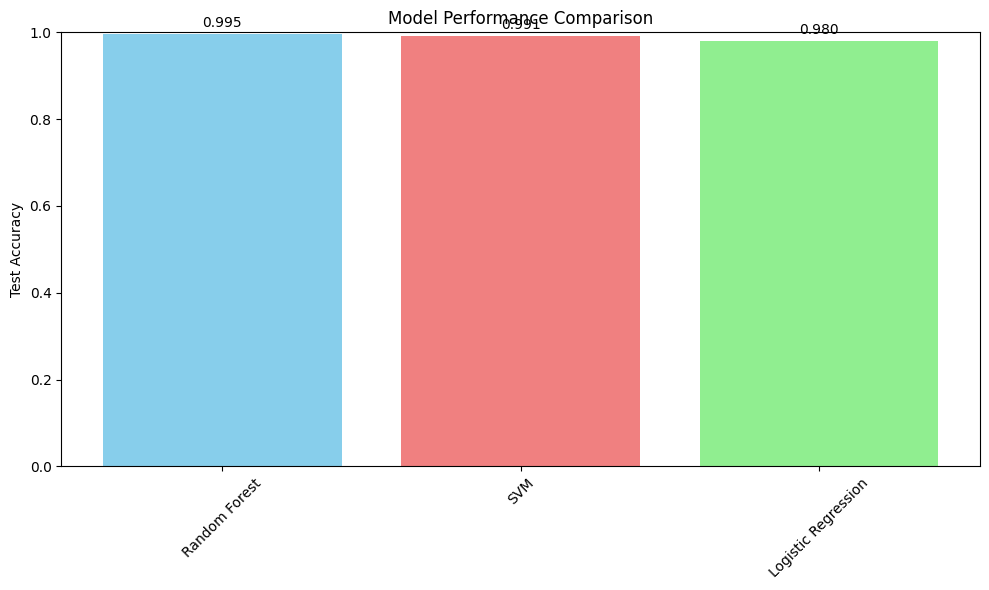


Best Model: Random Forest
Best Test Accuracy: 0.9955

Classification Report for Random Forest:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      

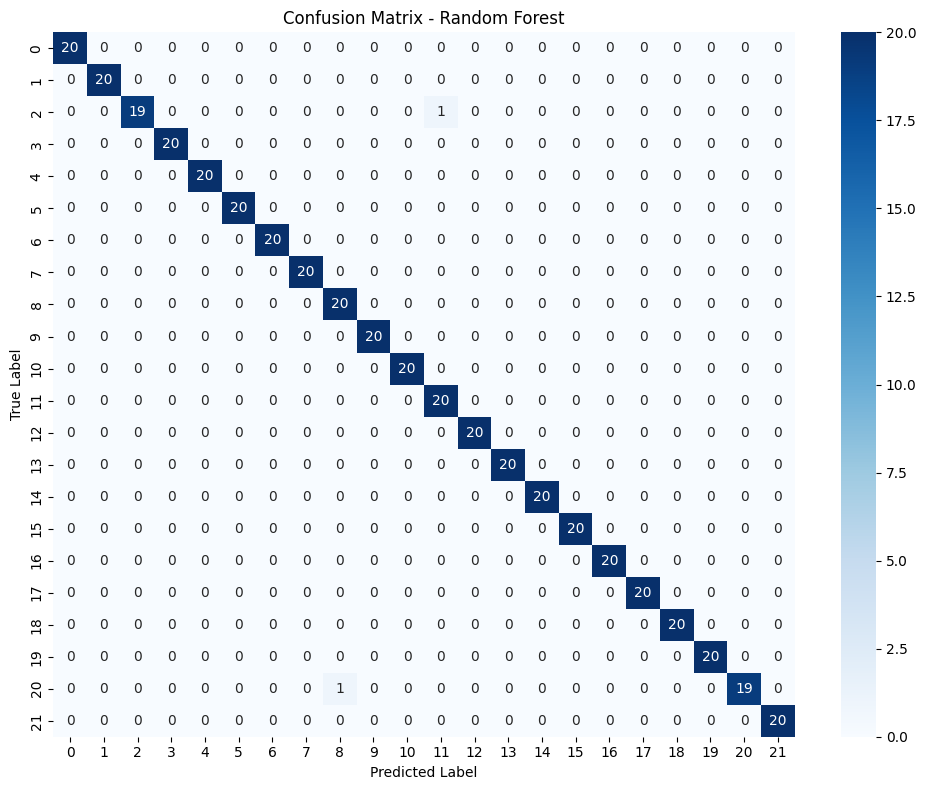


=== DATA QUALITY ASSESSMENT ===
Dataset Size: 2200 samples, 8 features
Number of classes: 22
Class imbalance ratio: 1.00
Missing data: 0.00%
Best model accuracy: 0.9955

--- DATA QUALITY VERDICT ---
✅ EXCELLENT: Data appears to be well-suited for machine learning
   - Good dataset size
   - Balanced classes
   - Minimal missing data
   - High model performance

🎯 PIPELINE COMPLETED SUCCESSFULLY!


In [11]:
def run_complete_pipeline(file_path):
    """Run the complete data cleaning and ML pipeline"""
    print("🚀 STARTING CROP RECOMMENDATION PIPELINE")
    print("=" * 50)
    
    # 1. Load data
    df = load_data(file_path)
    if df is None:
        return
    
    # 2. Clean data
    df_clean = clean_data(df)
    
    # 3. Analyze data
    analyze_data(df_clean)
    
    # 4. Prepare data and run ML models
    X, y, label_encoder, feature_cols = prepare_data(df_clean)
    results, X_test, y_test = evaluate_models(X, y)
    
    # 5. Analyze results
    best_model_name, best_model = analyze_results(results, X_test, y_test, label_encoder)
    
    # 6. Assess data quality
    quality_metrics = assess_data_quality(df_clean, results)
    
    print("\n" + "=" * 50)
    print("🎯 PIPELINE COMPLETED SUCCESSFULLY!")
    
    return {
        'cleaned_data': df_clean,
        'best_model': best_model,
        'best_model_name': best_model_name,
        'feature_columns': feature_cols,
        'label_encoder': label_encoder,
        'quality_metrics': quality_metrics
    }

# Run the complete pipeline
pipeline_results = run_complete_pipeline('crop_recommendation.csv')  # Replace with your file path